In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.save_account('97d2733b7c11b188b0581ae8a2beda54ce1c210ae0274df456ec1ddbe7df9fddf6d104015c59d4f7ce651304bf82fbd8e7178ea759d5f6f8058950d9e7ebf2ad',overwrite=True)

In [2]:
IBMQ.load_account()
backendStateVec = Aer.get_backend("statevector_simulator")
backendUnitary = Aer.get_backend('unitary_simulator')
backendQasm = Aer.get_backend("qasm_simulator")

def simul(qc):
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc,backend,shots=3000).result().get_counts()
    return result

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
#provider.backends()

In [4]:
from qiskit.providers.ibmq import least_busy
minQubits = 10

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > minQubits  and
                                                       not x.configuration().simulator)
leastBusybackend = least_busy(large_enough_devices)


In [29]:
def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs)

def printFound(results,collisions):
    for key in results:
        if(result_counts[key]>collisions):
          print(key, '->', result_counts[key])

In [6]:
def markedList(markedList,N):
    oracleList = np.ones(2**N)
    for element in markedList:
        oracleList[element] = -1
    return oracleList.tolist()


def oracle(markedList,N):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='Oracle')
    qc.diagonal(markedList,qreg)
    return qc


def diffusion(N):
    qreg = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,name='Diffusion')
    difCirc.h(qreg)
    
    aux = markedList([0],N)
    qcAux = oracle(aux,N)
    difCirc.append(qcAux,range(N))
    
    difCirc.h(qreg)
    return difCirc

def grover(marked,N,steps):
    qc = QuantumCircuit(N,N)
    qcOracle = oracle(markedList(marked,N),N)
    qcDiffusion = diffusion(N)
    qc.h(range(N))

    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.barrier()
        qc.append(qcDiffusion,range(N))
        qc.barrier()

    qc = transpile(qc,basis_gates=['cx','u3','h'],optimization_level=3)
    qc.barrier()
    qc.measure(range(N),range(N))
    return qc

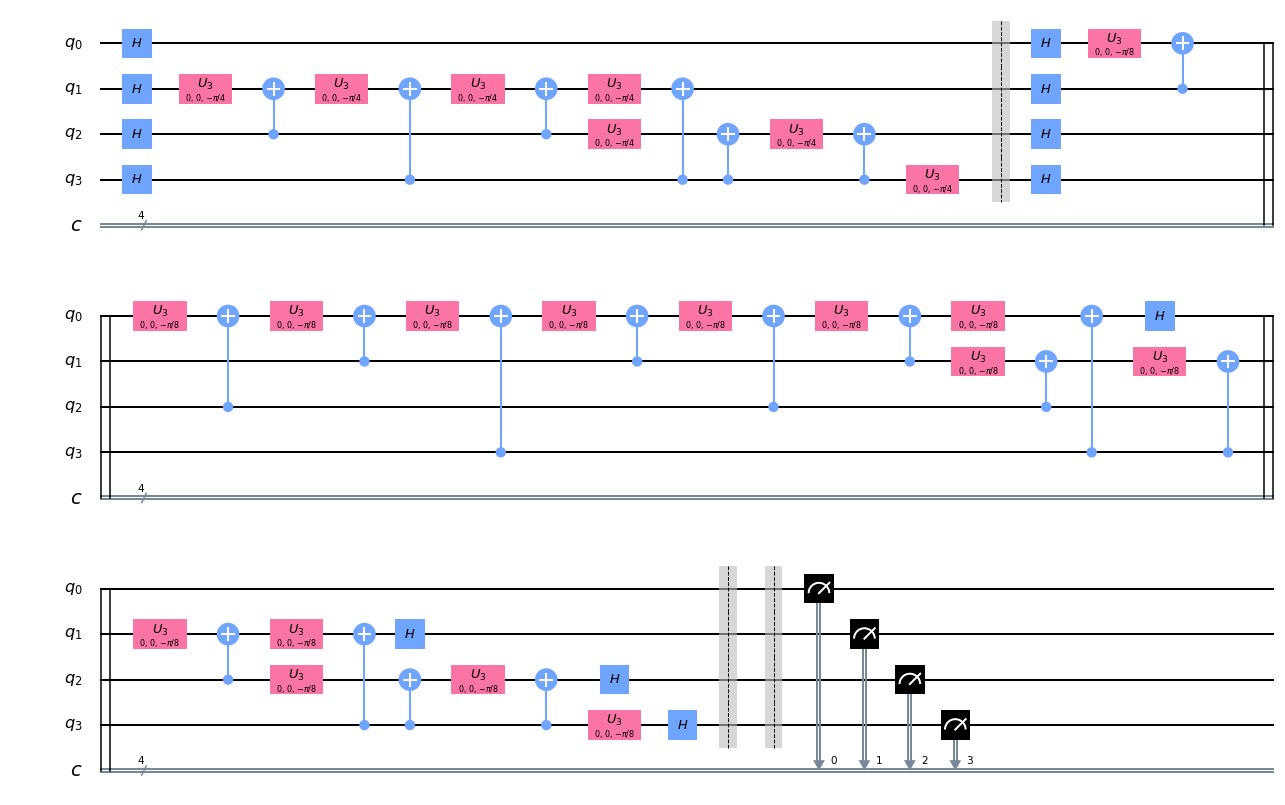

In [21]:
N=4
limit = 2**N -1

#qc = grover([0,1,int(limit/2),limit-1,limit],N,3)
qc = grover([0,1],N,1)
qc.draw(output='mpl')

In [30]:
print("The best backend is " + leastBusybackend.name())
result = run(qc,leastBusybackend)
#histogram(result)
leastBusybackend.jobs(limit=50, skip=0, status=None, db_filter=None)

The best backend is ibmq_johannesburg


[IBMQJob(_api=<qiskit.providers.ibmq.api.clients.account.AccountClient object at 0x0000027E22BAAC70>, _api_status='VALIDATING', _backend=<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>, _backend_info={'id': '5d7bbf8e02c24474838ac5ee', 'name': 'ibmq_johannesburg'}, _cancelled=False, _creation_date=datetime.datetime(2020, 6, 27, 12, 20, 40, 146000, tzinfo=tzutc()), _error=None, _job_error_msg=None, _job_id='5ef73998ddb6500012079e9e', _kind=<ApiJobKind.QOBJECT_STORAGE: 'q-object-external-storage'>, _name=None, _qobj=None, _queue_info=None, _result=None, _run_mode=None, _status=<JobStatus.VALIDATING: 'job is being validated'>, _tags=[], _time_per_step=None, _use_object_storage=True, hub_info={'hub': {'name': 'ibm-q-minho'}, 'group': {'name': 'academicprojects'}, 'project': {'name': 'quantalab'}}, share_level='none', user_id='5e4ffa1c390bdf0018f6f694'),
 IBMQJob(_api=<qiskit.providers.ibmq.api.clients.account.AccountClient objec

In [28]:
#print(result)
jobID = result.job_id()
job = leastBusybackend.retrieve_job(jobID)
resultCount = job.result().get_counts()

AttributeError: 'dict' object has no attribute 'job_id'

In [ ]:
job_monitor(result)

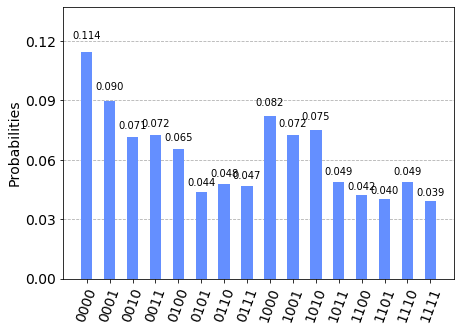

In [27]:
plot_histogram(resultCount)

In [ ]:
leastBusybackend.jobs(limit=50, skip=0, status=None, db_filter=None)